# Mounting

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Files

In [ ]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import seaborn as sns
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

from PIL import Image
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, load_img


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

from PIL import Image, ImageDraw, ImageFont

from sklearn.metrics import mean_squared_error

from sklearn.metrics import accuracy_score

from tensorflow.keras.callbacks import EarlyStopping


# Load Data

In [ ]:
# # Path to the CSV file
# csv_file_path = '/content/drive/MyDrive/Research Materials/Intrusion Detection/data/version_2/balanced_final_data.csv'

# data = pd.read_csv(csv_file_path)

# # Save the DataFrame as a Parquet file
# parquet_file_path = '/content/drive/MyDrive/Research Materials/Intrusion Detection/data/version_2/data.parquet'
# data.to_parquet(parquet_file_path, index=False)
# data

In [ ]:
# parquet_file_path = '/content/drive/MyDrive/Intrusion Detection/data/version_2/before_balanced_data.parquet'
parquet_file_path = '/content/drive/MyDrive/Research Materials/Intrusion Detection/data/version_2/data.parquet'


In [ ]:
# Load the Parquet file to verify
data = pd.read_parquet(parquet_file_path)
data.head()

IPV4_SRC_ADDR  L4_SRC_PORT IPV4_DST_ADDR  L4_DST_PORT  PROTOCOL  \
0     172.31.66.17        51128  23.36.69.189          443         6   
1    34.195.59.178          443  172.31.66.17        51036         6   
2  112.215.171.212        12262  172.31.66.17          445         6   
3     172.31.66.17        61023    172.31.0.2           53        17   
4   34.204.112.168          443  172.31.66.17        51037         6   

   L7_PROTO  IN_BYTES  OUT_BYTES  IN_PKTS  OUT_PKTS  TCP_FLAGS  \
0    91.000       152          0        3         0        194   
1    91.178       994        979        7         7         24   
2     0.000       585        344        5         4         30   
3     0.000       136        168        2         2          0   
4    91.178        72         40        1         1         24   

   FLOW_DURATION_MILLISECONDS  Label  Attack  
0                     4285680      0  Benign  
1                     4234714      0  Benign  
2                     4294106      0  Benign  
3                     4293985      0  Benign  
4                     4294845      0  Benign

In [ ]:
class_counts = data['Attack'].value_counts()
print(class_counts)

Attack
Benign                      7373198
DDoS attacks-LOIC-HTTP       378199
FTP-BruteForce               193360
DoS attacks-Hulk             108136
DoS attacks-SlowHTTPTest     105550
SSH-Bruteforce                94237
Infilteration                 62072
DoS attacks-GoldenEye         32850
DoS attacks-Slowloris         22825
Bot                           15683
Brute Force -Web               2613
Brute Force -XSS               1745
DDOS attack-LOIC-UDP           1667
DDOS attack-HOIC                230
SQL Injection                    36
Name: count, dtype: int64


In [ ]:
# Set the number of samples you want per class
sample_size = 22825

balanced_data = data.groupby('Attack').apply(lambda x: x.sample(n=sample_size, random_state=42))

# Reset the index after grouping
balanced_data = balanced_data.reset_index(drop=True)

# Check the balanced dataset
print(balanced_data['Attack'].value_counts())

In [ ]:
balanced_data.head()

# Exploratory Data Analysis

In [ ]:
# Convert IP addresses and other categorical data to numerical data
label_encoders = {}
categorical_columns = ['IPV4_SRC_ADDR', 'IPV4_DST_ADDR']  # Add other categorical columns if necessary

for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# Separate features and labels
features = data.drop(columns=['Attack'])
labels = data['Attack']

In [ ]:
# Normalize the features
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

# Combine scaled features and labels back into a DataFrame
data_scaled = pd.DataFrame(features_scaled, columns=features.columns)
data_scaled['Attack'] = labels.values

In [ ]:
data = data_scaled

In [ ]:
# Checking for missing values
missing_values = data.isnull().sum()
missing_values

IPV4_SRC_ADDR                 0
L4_SRC_PORT                   0
IPV4_DST_ADDR                 0
L4_DST_PORT                   0
PROTOCOL                      0
L7_PROTO                      0
IN_BYTES                      0
OUT_BYTES                     0
IN_PKTS                       0
OUT_PKTS                      0
TCP_FLAGS                     0
FLOW_DURATION_MILLISECONDS    0
Label                         0
Attack                        0
dtype: int64

In [ ]:
# Select numeric columns
numeric_cols = data.select_dtypes(include=['number']).columns.tolist()
print("Numeric columns:", numeric_cols)

# Select categorical columns
categorical_cols = data.select_dtypes(exclude=['number']).columns.tolist()
print("Categorical columns:", categorical_cols)

Numeric columns: ['IPV4_SRC_ADDR', 'L4_SRC_PORT', 'IPV4_DST_ADDR', 'L4_DST_PORT', 'PROTOCOL', 'L7_PROTO', 'IN_BYTES', 'OUT_BYTES', 'IN_PKTS', 'OUT_PKTS', 'TCP_FLAGS', 'FLOW_DURATION_MILLISECONDS', 'Label']
Categorical columns: ['Attack']


In [ ]:
# Distribution of the target variable 'Label'
# plt.figure(figsize=(10, 6))
# sns.countplot(data['Label'])
# plt.title('Distribution of Attack Labels')
# plt.xlabel('Label')
# plt.ylabel('Count')
# plt.show()

# Target Class


In [ ]:
class_counts = data['Attack'].value_counts()
print(class_counts)

Attack
Benign                      7373198
DDoS attacks-LOIC-HTTP       378199
FTP-BruteForce               193360
DoS attacks-Hulk             108136
DoS attacks-SlowHTTPTest     105550
SSH-Bruteforce                94237
Infilteration                 62072
DoS attacks-GoldenEye         32850
DoS attacks-Slowloris         22825
Bot                           15683
Brute Force -Web               2613
Brute Force -XSS               1745
DDOS attack-LOIC-UDP           1667
DDOS attack-HOIC                230
SQL Injection                    36
Name: count, dtype: int64


<ipython-input-13-be184fcff630>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')


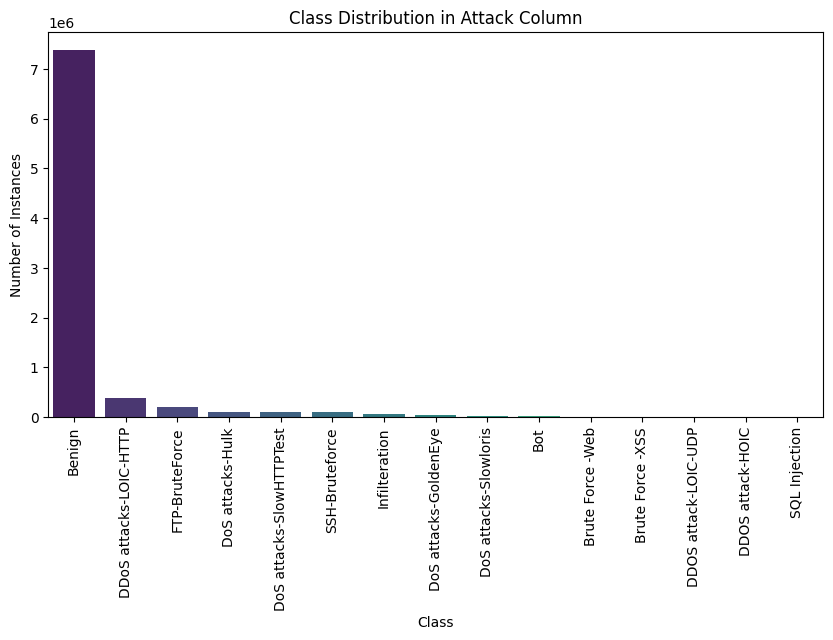

In [ ]:
# Bar chart for class distribution
plt.figure(figsize=(10, 5))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.title('Class Distribution in Attack Column')
plt.xlabel('Class')
plt.ylabel('Number of Instances')
plt.xticks(rotation=90)
plt.show()

In [ ]:
top_9_categories = class_counts.index[:9].tolist()
print("Top 9 categories:", top_9_categories)


Top 9 categories: ['Benign', 'DDoS attacks-LOIC-HTTP', 'FTP-BruteForce', 'DoS attacks-Hulk', 'DoS attacks-SlowHTTPTest', 'SSH-Bruteforce', 'Infilteration', 'DoS attacks-GoldenEye', 'DoS attacks-Slowloris']


In [ ]:
data = data[data['Attack'].isin(top_9_categories)]
data.head()

IPV4_SRC_ADDR  L4_SRC_PORT  IPV4_DST_ADDR  L4_DST_PORT  PROTOCOL  L7_PROTO  \
0       0.279322     0.780163       0.470649     0.006760  0.103448  0.366935   
1       0.748090     0.006760       0.244468     0.778759  0.103448  0.367653   
2       0.071230     0.187106       0.244468     0.006790  0.103448  0.000000   
3       0.279322     0.931151       0.239411     0.000809  0.293103  0.000000   
4       0.749098     0.006760       0.244468     0.778775  0.103448  0.367653   

   IN_BYTES     OUT_BYTES   IN_PKTS  OUT_PKTS  TCP_FLAGS  \
0  0.000006  0.000000e+00  0.000011  0.000000   0.869955   
1  0.000041  4.572142e-06  0.000025  0.000049   0.107623   
2  0.000024  1.606554e-06  0.000018  0.000028   0.134529   
3  0.000006  7.845963e-07  0.000007  0.000014   0.000000   
4  0.000003  1.868086e-07  0.000004  0.000007   0.107623   

   FLOW_DURATION_MILLISECONDS  Label  Attack  
0                    0.997838    0.0  Benign  
1                    0.985971    0.0  Benign  
2                    0.999800    0.0  Benign  
3                    0.999771    0.0  Benign  
4                    0.999972    0.0  Benign

In [ ]:
class_counts = data['Attack'].value_counts()
print(class_counts)

Attack
Benign                      7373198
DDoS attacks-LOIC-HTTP       378199
FTP-BruteForce               193360
DoS attacks-Hulk             108136
DoS attacks-SlowHTTPTest     105550
SSH-Bruteforce                94237
Infilteration                 62072
DoS attacks-GoldenEye         32850
DoS attacks-Slowloris         22825
Name: count, dtype: int64


<ipython-input-17-be184fcff630>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')


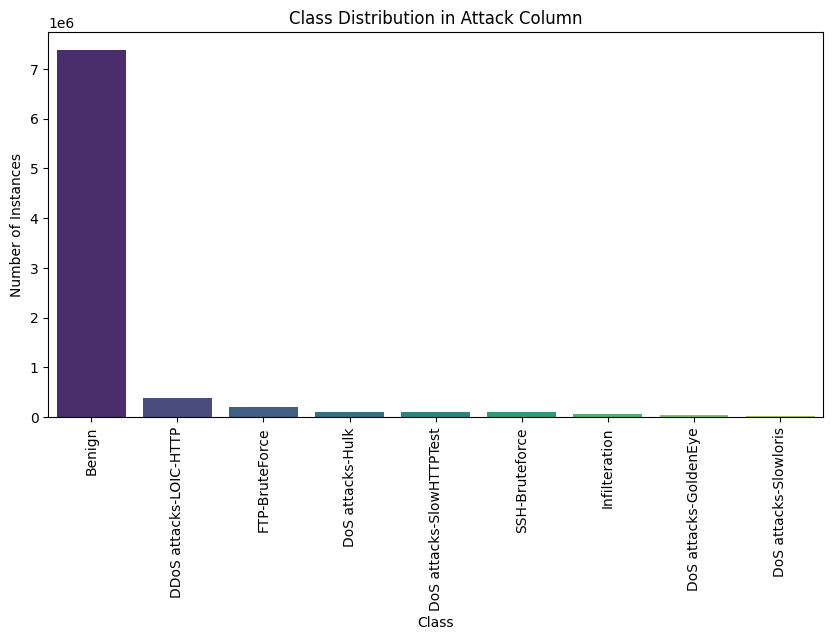

In [ ]:
# Bar chart for class distribution
plt.figure(figsize=(10, 5))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.title('Class Distribution in Attack Column')
plt.xlabel('Class')
plt.ylabel('Number of Instances')
plt.xticks(rotation=90)
plt.show()

In [ ]:
# before_balanced_data_path = '/content/drive/MyDrive/Research Materials/Intrusion Detection/data/version_2/before_balanced_data.parquet'
# data.to_parquet(before_balanced_data_path, index=False)

# Balance the dataset using GAN

In [ ]:
# Function to build the GAN components
def build_generator(input_dim, output_dim):
    model = tf.keras.Sequential([
        layers.Dense(128, input_dim=input_dim, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dense(512, activation='relu'),
        layers.Dense(output_dim, activation='tanh')
    ])
    return model

def build_discriminator(input_dim):
    model = tf.keras.Sequential([
        layers.Dense(512, input_dim=input_dim, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

def build_gan(generator, discriminator):
    model = tf.keras.Sequential([generator, discriminator])
    return model

def train_gan(gan, generator, discriminator, data, epochs=100, batch_size=64, early_stop_epoch=20):
    half_batch = int(batch_size / 2)
    input_dim = data.shape[1]
    for epoch in range(epochs):
        # Train discriminator
        idx = np.random.randint(0, data.shape[0], half_batch)
        real_data = data[idx]
        noise = np.random.normal(0, 1, (half_batch, input_dim))
        fake_data = generator.predict(noise)

        d_loss_real = discriminator.train_on_batch(real_data, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(fake_data, np.zeros((half_batch, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train generator
        noise = np.random.normal(0, 1, (batch_size, input_dim))
        valid_y = np.array([1] * batch_size)
        g_loss = gan.train_on_batch(noise, valid_y)

        # Print progress every 100 epochs
        if epoch % 100 == 0:
            print(f"{epoch} [D loss: {d_loss}] [G loss: {g_loss}]")

        # Stop early if the specified number of epochs is reached
        if epoch >= early_stop_epoch:
            break


In [ ]:
# Function to generate synthetic data for a specific class
def generate_synthetic_data(class_name, class_data, benign_data_length, save_path):
    class_features = class_data.drop(columns=['Attack'])

    # Define GAN input and output dimensions
    input_dim = class_features.shape[1]
    output_dim = input_dim

    # Build GAN components
    generator = build_generator(input_dim, output_dim)
    discriminator = build_discriminator(output_dim)
    discriminator.compile(optimizer='adam', loss='binary_crossentropy')

    gan = build_gan(generator, discriminator)
    gan.compile(optimizer='adam', loss='binary_crossentropy')

    # Train the GAN
    train_gan(gan, generator, discriminator, class_features.values, epochs=100, batch_size=64, early_stop_epoch=20)

    # Generate synthetic data
    noise = np.random.normal(0, 1, (benign_data_length - len(class_data), input_dim))
    synthetic_data = generator.predict(noise)

    # Create a DataFrame for synthetic data
    synthetic_data_df = pd.DataFrame(synthetic_data, columns=class_features.columns)
    synthetic_data_df['Attack'] = class_name

    # Save synthetic data to Parquet file
    synthetic_data_df.to_parquet(save_path, index=False)

# Separate the classes
benign_data = data_scaled[data_scaled['Attack'] == 'Benign']
benign_data_length = len(benign_data)

underrepresented_classes = {
    'DDoS attacks-LOIC-HTTP': 378199,
    'FTP-BruteForce': 193360,
    'DoS attacks-Hulk': 108136,
    'DoS attacks-SlowHTTPTest': 105550,
    'SSH-Bruteforce': 94237,
    'Infilteration': 62072,
    'DoS attacks-GoldenEye': 32850,
    'DoS attacks-Slowloris': 22825
}

# Generate and save synthetic data for each underrepresented class
for attack_class, _ in underrepresented_classes.items():
    class_data = data_scaled[data_scaled['Attack'] == attack_class]
    save_path = f'/content/drive/MyDrive/Research Materials/Intrusion Detection/data/version_2/balanced_data_synthetic_{attack_class.replace(" ", "_")}.parquet'
    generate_synthetic_data(attack_class, class_data, benign_data_length, save_path)


In [ ]:
underrepresented_classes = {
    'DDoS attacks-LOIC-HTTP': 378199,
    'FTP-BruteForce': 193360,
    'DoS attacks-Hulk': 108136,
    'DoS attacks-SlowHTTPTest': 105550,
    'SSH-Bruteforce': 94237,
    'Infilteration': 62072,
    'DoS attacks-GoldenEye': 32850,
    'DoS attacks-Slowloris': 22825
}

In [ ]:
# Load the original benign data
balanced_data = data.copy()

# Combine synthetic data files
for attack_class in underrepresented_classes.keys():
    save_path = f'/content/drive/MyDrive/Research Materials/Intrusion Detection/data/version_2/balanced_data_synthetic_{attack_class.replace(" ", "_")}.parquet'
    synthetic_data_df = pd.read_parquet(save_path)
    class_data = data_scaled[data_scaled['Attack'] == attack_class]
    balanced_data = pd.concat([balanced_data, class_data, synthetic_data_df], ignore_index=True)

# Shuffle the balanced dataset
# balanced_data = balanced_data.sample(frac=1).reset_index(drop=True)


In [ ]:
# Save the final balanced dataset to Google Drive
balanced_data.to_parquet('/content/drive/MyDrive/Research Materials/Intrusion Detection/data/version_2/balanced_data_final.parquet', index=False)

# Display the distribution of the balanced dataset
balanced_class_counts = balanced_data['Attack'].value_counts()
print(balanced_class_counts)



In [ ]:
# Visualize the balanced class distribution
plt.figure(figsize=(12, 8))
sns.barplot(x=balanced_class_counts.index, y=balanced_class_counts.values, palette='viridis')
plt.title('Class Distribution in Attack Column (Balanced)')
plt.xlabel('Class')
plt.ylabel('Number of Instances')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

# Marge All Balanced Data

In [ ]:

file_paths = [
    '/content/drive/MyDrive/Research Materials/Intrusion Detection/data/version_2/balanced_data_synthetic_DDoS_attacks-LOIC-HTTP.parquet',
    '/content/drive/MyDrive/Research Materials/Intrusion Detection/data/version_2/balanced_data_synthetic_FTP-BruteForce.parquet',
    '/content/drive/MyDrive/Research Materials/Intrusion Detection/data/version_2/balanced_data_synthetic_DoS_attacks-Hulk.parquet',
    '/content/drive/MyDrive/Research Materials/Intrusion Detection/data/version_2/balanced_data_synthetic_DoS_attacks-SlowHTTPTest.parquet',
    '/content/drive/MyDrive/Research Materials/Intrusion Detection/data/version_2/balanced_data_synthetic_SSH-Bruteforce.parquet',
    '/content/drive/MyDrive/Intrusion Detection/data/version_2/balanced_data_synthetic_Infilteration.parquet',
    '/content/drive/MyDrive/Intrusion Detection/data/version_2/balanced_data_synthetic_DoS_attacks-GoldenEye.parquet',
    '/content/drive/MyDrive/Intrusion Detection/data/version_2/balanced_data_synthetic_DoS_attacks-Slowloris.parquet',
    '/content/drive/MyDrive/Intrusion Detection/data/version_2/balanced_final_data.parquet'
]

# Load and concatenate the Parquet files
dataframes = [pd.read_parquet(file_path) for file_path in file_paths]
balanced_data = pd.concat(dataframes, ignore_index=True)

# Save the combined DataFrame to a new Parquet file
balanced_data.to_parquet('/content/drive/MyDrive/Intrusion Detection/data/version_2/balanced_final_data.parquet', index=False)

print("Combined data shape:", balanced_data.shape)


Combined data shape: (66358782, 14)


In [ ]:
# Specify the path to your Parquet file
file_path = '/content/drive/MyDrive/Intrusion Detection/data/version_2/balanced_final_data.parquet'
# file_path = '/content/drive/MyDrive/Research Materials/Intrusion Detection/data/version_2/balanced_final_data.parquet'

# Read the Parquet file into a DataFrame
df = pd.read_parquet(file_path)

# # Display the DataFrame
# print(df)

In [ ]:
data = df
data.head()

IPV4_SRC_ADDR  L4_SRC_PORT  IPV4_DST_ADDR  L4_DST_PORT  PROTOCOL  L7_PROTO  \
0       0.999504     0.999978       0.998774     0.923359  0.997616  0.996140   
1       0.999996     1.000000       0.999993     0.995572  0.999962  0.999916   
2       0.999993     1.000000       0.999992     0.993916  0.999966  0.999910   
3       0.999991     1.000000       0.999988     0.990731  0.999939  0.999845   
4       0.999979     1.000000       0.999942     0.984444  0.999716  0.999649   

   IN_BYTES  OUT_BYTES   IN_PKTS  OUT_PKTS  TCP_FLAGS  \
0  0.996484   0.798330 -0.994457  0.999400   0.971569   
1  0.999939   0.893131 -0.999882  0.999997   0.997938   
2  0.999936   0.913746 -0.999832  0.999995   0.995465   
3  0.999833   0.859489 -0.999813  0.999996   0.994277   
4  0.999571   0.841915 -0.999277  0.999975   0.994627   

   FLOW_DURATION_MILLISECONDS     Label         Attack  
0                    0.999824  0.999960  Infilteration  
1                    0.999999  1.000000  Infilteration  
2                    0.999999  1.000000  Infilteration  
3                    0.999998  1.000000  Infilteration  
4                    0.999990  0.999999  Infilteration

In [ ]:
# Display the distribution of the balanced dataset
balanced_class_counts = data['Attack'].value_counts()
print(balanced_class_counts)

Attack
Infilteration               7373198
DoS attacks-GoldenEye       7373198
DoS attacks-Slowloris       7373198
SSH-Bruteforce              7373198
DoS attacks-SlowHTTPTest    7373198
DoS attacks-Hulk            7373198
FTP-BruteForce              7373198
DDoS attacks-LOIC-HTTP      7373198
Benign                      7373198
Name: count, dtype: int64


<ipython-input-17-bc7dbcf02d32>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=balanced_class_counts.index, y=balanced_class_counts.values, palette='viridis')


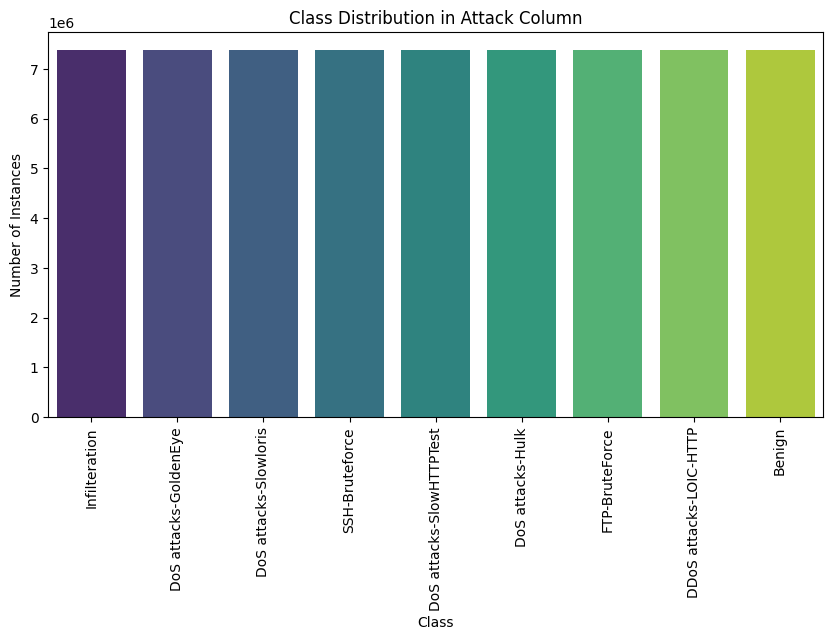

In [ ]:
# Bar chart for class distribution
plt.figure(figsize=(10, 5))
sns.barplot(x=balanced_class_counts.index, y=balanced_class_counts.values, palette='viridis')
plt.title('Class Distribution in Attack Column')
plt.xlabel('Class')
plt.ylabel('Number of Instances')
plt.xticks(rotation=90)
plt.show()

# Apply CNN Algorithm


In [ ]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Separate features and target
X = data.drop(columns=['Attack'])
y = data['Attack']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Encode target
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(6696341, 13)
(1674086, 13)
(6696341,)
(1674086,)


In [ ]:
import numpy as np
class_a = np.unique(y_train)
print(class_a)

[0 1 2 3 4 5 6 7 8]


In [ ]:
# Reshape the data for Conv1D
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

num_classes = len(data['Attack'].unique())

# One-hot encode the target labels
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

# Define the model
model = Sequential([

    # Define the input layer explicitly
    Input(shape=(13, 1)),

    # First Convolutional Layer with Batch Normalization
    Conv1D(filters=64, kernel_size=2, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    # Second Convolutional Layer with Batch Normalization
    Conv1D(filters=64, kernel_size=2, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    # Flatten the output
    Flatten(),

    # First Dense Layer with reduced neurons and dropout
    Dense(128, activation='relu'),
    Dropout(0.4),

    # Second Dense Layer
    Dense(64, activation='relu'),
    Dropout(0.4),

    # Output Layer
    Dense(num_classes, activation='softmax')
])

model.summary()
# # Compile the model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# # Early stopping to prevent overfitting
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Model fitting with EarlyStopping
# history = model.fit(X_train_cnn, y_train, epochs=200, validation_data=(X_test_cnn, y_test),
#                     batch_size=32, callbacks=[early_stopping])


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)                    │ (None, 12, 64)              │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 12, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 6, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 5, 64)               │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 5, 64)               │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 2, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 9)                   │             585 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 34,313 (134.04 KB)

 Trainable params: 34,057 (133.04 KB)

 Non-trainable params: 256 (1.00 KB)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

num_classes = len(data['Attack'].unique())

# # One-hot encode the target labels
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

# Define the model
model = Sequential([

    # Define the input layer explicitly
    Input(shape=(13, 1)),

    # First LSTM Layer
    LSTM(64, return_sequences=True),
    Dropout(0.4),

    # Second LSTM Layer
    LSTM(64, return_sequences=True),
    Dropout(0.4),

    # Convolutional Layer for Feature Extraction with Batch Normalization
    Conv1D(filters=64, kernel_size=2, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    # Flatten the output
    Flatten(),

    # First Dense Layer with reduced neurons and dropout
    Dense(128, activation='relu'),
    Dropout(0.4),

    # Second Dense Layer
    Dense(64, activation='relu'),
    Dropout(0.4),

    # Output Layer
    Dense(num_classes, activation='softmax')
])

# Compile the model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Model fitting with EarlyStopping
# history = model.fit(X_train_cnn, y_train, epochs=100, validation_data=(X_test_cnn, y_test),
#                     batch_size=32, callbacks=[early_stopping])

# history = model.fit(X_train_cnn, y_train, epochs=5, validation_data=(X_test_cnn, y_test),
#                     batch_size=32)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 13, 64)              │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 13, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 13, 64)              │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 13, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 12, 64)              │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 12, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 6, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 384)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          49,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 9)                   │             585 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 116,553 (455.29 KB)

 Trainable params: 116,425 (454.79 KB)

 Non-trainable params: 128 (512.00 B)

In [ ]:
print(f"X_train_cnn shape: {X_train_cnn.shape}")
print(f"X_test_cnn shape: {X_test_cnn.shape}")


X_train_cnn shape: (164340, 13, 1)
X_test_cnn shape: (41085, 13, 1)


In [ ]:
!pip install lime

In [ ]:
import lime
import lime.lime_tabular
import numpy as np

# Get feature names
feature_names = data.drop(['Attack'], axis=1).columns.tolist()  # Exclude label and attack columns
print("Feature Names:")
print(feature_names)

# Initialize LIME Explainer for tabular data
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train,  # Your training data
    feature_names=feature_names,  # Feature names
    class_names=['Benign',
    'DDoS attacks-LOIC-HTTP',
    'DoS attacks-GoldenEye',
    'DoS attacks-Hulk',
    'DoS attacks-SlowHTTPTest',
    'DoS attacks-Slowloris',
    'FTP-BruteForce',
    'Infilteration',
    'SSH-Bruteforce'],
    mode='classification'
)
state_size = 13

# Choose a sample input to explain (can be random or specific)
sample_idx = np.random.randint(0, X_test.shape[0])  # Pick a random test instance
sample_input = np.reshape(X_test[sample_idx], [1, state_size])

# Get the model's prediction for the sample input
predicted_proba = model.predict(sample_input)

# Explain the model's prediction using LIME
exp = explainer.explain_instance(
    data_row=X_test[sample_idx],  # The input you want to explain
    predict_fn=lambda x: model.predict(x),  # The prediction function
    num_features=state_size  # Number of features to show in the explanation
)

# Display the explanation in text format
print(f"Explanation for test instance {sample_idx}:")
exp.show_in_notebook(show_table=True)

# If using a notebook, you can save the explanation to an HTML file as well
exp.save_to_file(f"lime_explanation_instance_{sample_idx}.html")


Feature Names:
['IPV4_SRC_ADDR', 'L4_SRC_PORT', 'IPV4_DST_ADDR', 'L4_DST_PORT', 'PROTOCOL', 'L7_PROTO', 'IN_BYTES', 'OUT_BYTES', 'IN_PKTS', 'OUT_PKTS', 'TCP_FLAGS', 'FLOW_DURATION_MILLISECONDS', 'Label']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Explanation for test instance 24566:


In [ ]:
from google.colab import drive, files
# Get feature names
feature_names = data.drop(['Attack'], axis=1).columns.tolist()  # Exclude 'Attack' column
print("Feature Names:")
print(feature_names)

# Initialize LIME Explainer for tabular data
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train,  # Your training data
    feature_names=feature_names,  # Feature names
    class_names=['Benign',
    'DDoS attacks-LOIC-HTTP',
    'DoS attacks-GoldenEye',
    'DoS attacks-Hulk',
    'DoS attacks-SlowHTTPTest',
    'DoS attacks-Slowloris',
    'FTP-BruteForce',
    'Infilteration',
    'SSH-Bruteforce'],
    mode='classification'
)
state_size = 13

# Choose a sample input to explain
sample_idx = np.random.randint(0, X_test.shape[0])  # Random test instance
sample_input = np.reshape(X_test[sample_idx], [1, state_size])

# Get the model's prediction for the sample input
predicted_proba = model.predict(sample_input)

# Explain the model's prediction using LIME
exp = explainer.explain_instance(
    data_row=X_test[sample_idx],  # The input you want to explain
    predict_fn=lambda x: model.predict(x),  # The prediction function
    num_features=state_size  # Number of features to show in the explanation
)

print(f"Explanation for test instance {sample_idx}:")
exp.show_in_notebook(show_table=True)


# Save explanation as HTML in Google Drive
html_file_path = "/content/drive/MyDrive/Intrusion Detection/lime_explanation_instance.html"
exp.save_to_file(html_file_path)

# Save explanation as PNG in Google Drive
png_file_path = "/content/drive/MyDrive/Intrusion Detection/lime_explanation_instance.png"
fig = exp.as_pyplot_figure()
fig.savefig(png_file_path, format='png', bbox_inches='tight')
plt.close(fig)

# Optionally download files locally
files.download(html_file_path)
files.download(png_file_path)

Feature Names:
['IPV4_SRC_ADDR', 'L4_SRC_PORT', 'IPV4_DST_ADDR', 'L4_DST_PORT', 'PROTOCOL', 'L7_PROTO', 'IN_BYTES', 'OUT_BYTES', 'IN_PKTS', 'OUT_PKTS', 'TCP_FLAGS', 'FLOW_DURATION_MILLISECONDS', 'Label']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Explanation for test instance 6221:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Train the model
# history = model.fit(X_train_cnn, y_train, epochs=10, batch_size=64, validation_data=(X_test_cnn, y_test))
# Save the model
model.save('/content/drive/MyDrive/Intrusion Detection/models/model_LSTM_2.h5')

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

num_classes = len(data['Attack'].unique())

# One-hot encode the target labels
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

# Define the model
model = Sequential([

    # Define the input layer explicitly
    Input(shape=(13, 1)),

    # First Convolutional Layer with Batch Normalization
    Conv1D(filters=64, kernel_size=2, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    # Second Convolutional Layer with Batch Normalization
    Conv1D(filters=64, kernel_size=2, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    # Flatten the output
    Flatten(),

    # First Dense Layer with reduced neurons and dropout
    Dense(128, activation='relu'),
    Dropout(0.4),

    # Second Dense Layer
    Dense(64, activation='relu'),
    Dropout(0.4),

    # Output Layer
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Model fitting
history = model.fit(X_train_cnn, y_train, epochs=200, validation_data=(X_test_cnn, y_test), batch_size=32)


In [ ]:
num_classes = len(data['Attack'].unique())
num_classes

9

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

num_classes = len(data['Attack'].unique())

# Define the model
model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(13, 1)),
    MaxPooling1D(pool_size=2),

    Conv1D(filters=64, kernel_size=2, activation='relu'),
    MaxPooling1D(pool_size=2),

    Flatten(),

    Dense(100, activation='relu'),
    Dropout(0.5),

    Dense(200, activation='relu'),
    Dropout(0.5),

    Dense(300, activation='relu'),
    Dropout(0.5),

    Dense(400, activation='relu'),
    Dropout(0.5),

    Dense(num_classes, activation='softmax')
])

model = Sequential([

    # First Convolutional Layer with Batch Normalization
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(13, 1)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    # Second Convolutional Layer with Batch Normalization
    Conv1D(filters=64, kernel_size=2, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    # Flatten the output
    Flatten(),

    # First Dense Layer with reduced neurons and dropout
    Dense(128, activation='relu'),
    Dropout(0.4),

    # Second Dense Layer
    Dense(64, activation='relu'),
    Dropout(0.4),

    # Output Layer
    Dense(num_classes, activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# # Compile the model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# # Early stopping to prevent overfitting
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# # Summary of the model
# model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_12 (Conv1D)                   │ (None, 12, 64)              │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_12 (MaxPooling1D)      │ (None, 6, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_13 (Conv1D)                   │ (None, 5, 64)               │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_13 (MaxPooling1D)      │ (None, 2, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 100)                 │          12,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 200)                 │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 300)                 │          60,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 300)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 400)                 │         120,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 400)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 9)                   │           3,609 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 225,857 (882.25 KB)

 Trainable params: 225,857 (882.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

num_classes = len(data['Attack'].unique())

# Define the model
model = Sequential([

    # First Convolutional Layer with Batch Normalization
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(13, 1)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    # Second Convolutional Layer with Batch Normalization
    Conv1D(filters=64, kernel_size=2, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    # Flatten the output
    Flatten(),

    # First Dense Layer with reduced neurons and dropout
    Dense(128, activation='relu'),
    Dropout(0.4),

    # Second Dense Layer
    Dense(64, activation='relu'),
    Dropout(0.4),

    # Output Layer
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Model fitting
history = model.fit(X_train_cnn, y_train, epochs=200, validation_data=(X_test_cnn, y_test), batch_size=32, callbacks=[early_stopping])


In [ ]:
# Train the model
# history = model.fit(X_train_cnn, y_train, epochs=10, batch_size=64, validation_data=(X_test_cnn, y_test))
# Save the model
model.save('/content/drive/MyDrive/Intrusion Detection/models/model_LSTM_1.h5')

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/Intrusion Detection/models/model_LSTM_2.h5')

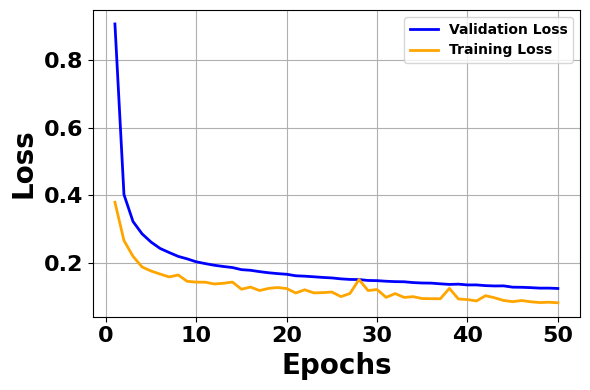

In [ ]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

# Extracting training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Get the number of epochs
epochs = range(1, len(train_loss) + 1)

# Create a new figure for the loss plot
plt.figure(figsize=(6, 4))

# Plotting the Training and Validation Loss with bold lines
plt.plot(epochs, train_loss, label='Validation Loss', color='blue', linewidth=2)  # Line boldness
plt.plot(epochs, val_loss, label='Training Loss', color='orange', linewidth=2)  # Line boldness

# Customize the plot
plt.xlabel('Epochs', fontsize=20, fontweight='bold')
plt.ylabel('Loss', fontsize=20, fontweight='bold')
plt.xticks(fontsize=16, fontweight='bold')
plt.yticks(fontsize=16, fontweight='bold')
plt.legend(fontsize=18, prop={'weight': 'bold'})  # Make the legend bold
plt.grid()

# Show the loss plot
plt.tight_layout()
plt.show()



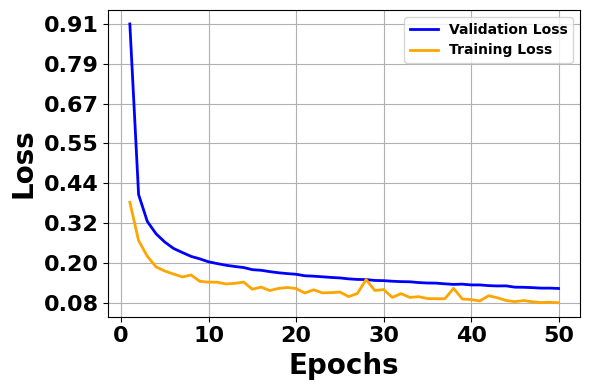

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter

# Extracting training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Get the number of epochs
epochs = range(1, len(train_loss) + 1)

# Create a new figure for the loss plot
plt.figure(figsize=(6, 4))

# Plotting the Training and Validation Loss with bold lines
plt.plot(epochs, train_loss, label='Validation Loss', color='blue', linewidth=2)  # Corrected label
plt.plot(epochs, val_loss, label='Training Loss', color='orange', linewidth=2)  # Corrected label

# Customize the plot
plt.xlabel('Epochs', fontsize=20, fontweight='bold')
plt.ylabel('Loss', fontsize=20, fontweight='bold')
plt.xticks(fontsize=16, fontweight='bold')
plt.yticks(fontsize=16, fontweight='bold')

# Set y-axis ticks to have exactly 8 points
min_loss = min(min(train_loss), min(val_loss))
max_loss = max(max(train_loss), max(val_loss))
yticks = np.linspace(min_loss, max_loss, 8)  # Create 8 evenly spaced ticks between min and max loss
plt.yticks(yticks)

# Use FuncFormatter to format y-axis ticks to 2 decimal places
formatter = FuncFormatter(lambda x, pos: f'{x:.2f}')  # Format to 2 decimal places
plt.gca().yaxis.set_major_formatter(formatter)

# Add a legend and grid
plt.legend(fontsize=18, prop={'weight': 'bold'})  # Make the legend bold
plt.grid()

# Show the loss plot
plt.tight_layout()
plt.show()


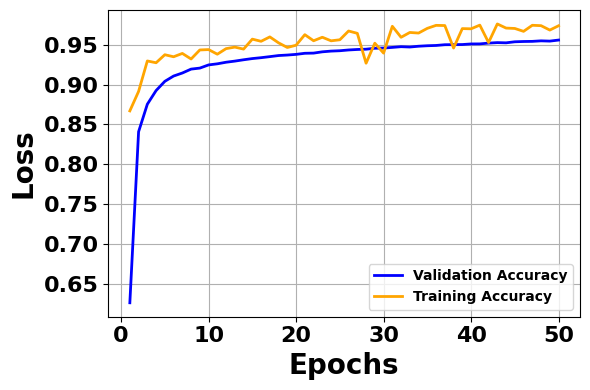

In [ ]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

# Extracting training history
train_loss = history.history['loss']
# val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

# Get the number of epochs
epochs = range(1, len(train_loss) + 1)

# Create a new figure for the loss plot
plt.figure(figsize=(6, 4))

# Plotting the Training and Validation Loss with bold lines
plt.plot(epochs, train_acc, label='Validation Accuracy', color='blue', linewidth=2)  # Line boldness
plt.plot(epochs, val_acc, label='Training Accuracy', color='orange', linewidth=2)  # Line boldness

# Customize the plot
plt.xlabel('Epochs', fontsize=20, fontweight='bold')
plt.ylabel('Loss', fontsize=20, fontweight='bold')
plt.xticks(fontsize=16, fontweight='bold')
plt.yticks(fontsize=16, fontweight='bold')
plt.legend(fontsize=18, prop={'weight': 'bold'})  # Make the legend bold
plt.grid()

# Show the loss plot
plt.tight_layout()
plt.show()



In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import SparseCategoricalAccuracy

# Load the model
model = load_model('/content/drive/MyDrive/Intrusion Detection/models/model_LSTM_2.h5')

# Recompile the model with the correct metric
model.compile(optimizer='SGD',
              loss='sparse_categorical_crossentropy',
              metrics=[SparseCategoricalAccuracy()])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_cnn, y_test)

# Print the results
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


1284/1284 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 0.0840 - sparse_categorical_accuracy: 0.9714
Test Loss: 0.08318975567817688
Test Accuracy: 0.9711086750030518


In [ ]:
model.history

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import numpy as np

# Step 1: Get predictions from the model
y_pred = model.predict(X_test)

# Step 2: Convert predictions to class labels if necessary
# If y_pred contains probabilities (e.g., from softmax), use argmax to get the predicted class indices
if y_pred.ndim > 1:  # Check if y_pred has probabilities in multiple columns
    y_pred_class = y_pred.argmax(axis=1)
else:
    y_pred_class = y_pred

# Step 3: Convert y_test to class labels if it's one-hot encoded
if y_test.ndim > 1:  # Check if y_test is one-hot encoded
    y_test_class = y_test.argmax(axis=1)
else:
    y_test_class = y_test

# Step 4: Calculate accuracy
accuracy = accuracy_score(y_test_class, y_pred_class)

# Step 5: Calculate precision, recall, and F1-score for each class
precision = precision_score(y_test_class, y_pred_class, average=None)
recall = recall_score(y_test_class, y_pred_class, average=None)
f1 = f1_score(y_test_class, y_pred_class, average=None)

# Step 6: Calculate weighted averages
precision_weighted = precision_score(y_test_class, y_pred_class, average='weighted')
recall_weighted = recall_score(y_test_class, y_pred_class, average='weighted')
f1_weighted = f1_score(y_test_class, y_pred_class, average='weighted')

# Step 7: Print the classification report
report = classification_report(y_test_class, y_pred_class)

print("Accuracy: ", accuracy)
print("Precision (per class): ", precision)
print("Recall (per class): ", recall)
print("F1-Score (per class): ", f1)
print("Weighted Precision: ", precision_weighted)
print("Weighted Recall: ", recall_weighted)
print("Weighted F1-Score: ", f1_weighted)
print("\nClassification Report:\n", report)


1284/1284 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step
Accuracy:  0.9737130339539978
Precision (per class):  [1.         0.9407828  0.98523524 0.9962197  1.         0.94123091
 0.90941456 1.         1.        ]
Recall (per class):  [1.         1.         0.87547254 0.9946714  1.         0.8913234
 1.         1.         1.        ]
F1-Score (per class):  [1.         0.96948798 0.92711645 0.99544495 1.         0.91559757
 0.95255852 1.         1.        ]
Weighted Precision:  0.9746168632325075
Weighted Recall:  0.9737130339539978
Weighted F1-Score:  0.9733925492481469

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4475
           1       0.94      1.00      0.97      4639
           2       0.99      0.88      0.93      4497
           3       1.00      0.99      1.00      4504
           4       1.00      1.00      1.00      4587
           5       0.94      0.89      0.92      4564
           6       0.91      1.0

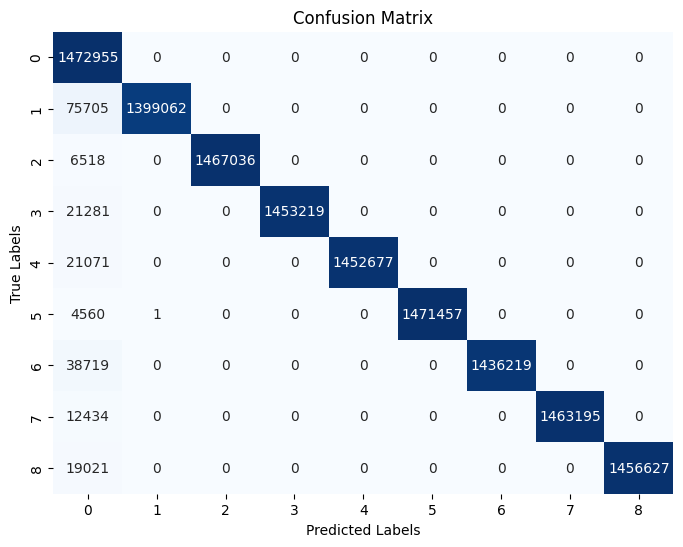

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Step 1: Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_class)

# Step 2: Plot the confusion matrix using seaborn's heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


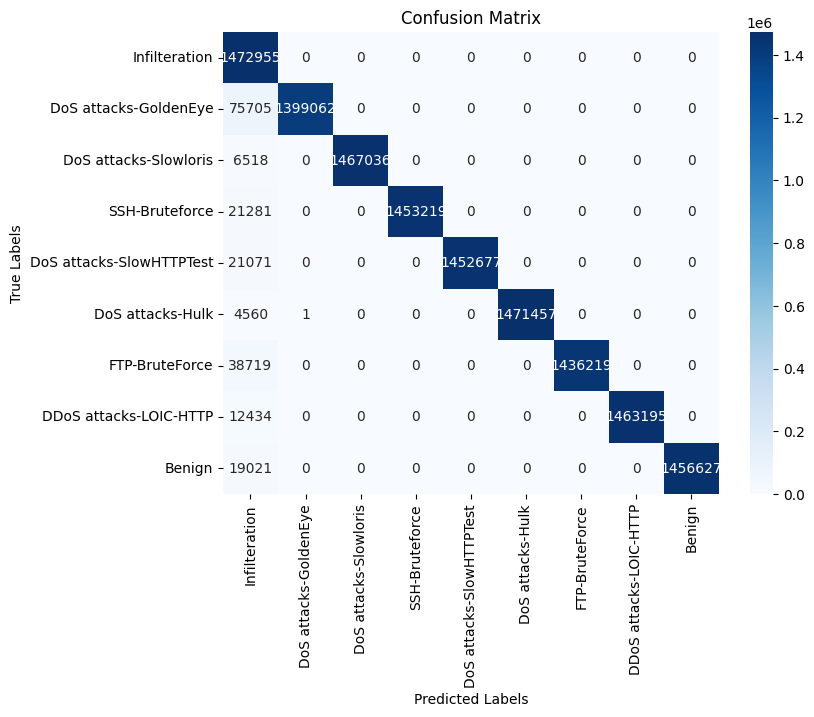

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define the class names
class_names = ['Infilteration', 'DoS attacks-GoldenEye', 'DoS attacks-Slowloris', 'SSH-Bruteforce', 'DoS attacks-SlowHTTPTest',
               'DoS attacks-Hulk', 'FTP-BruteForce', 'DDoS attacks-LOIC-HTTP', 'Benign']

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_class)

# Plot the confusion matrix with class names
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define the class names
class_names = ['Infilteration', 'DoS attacks-GoldenEye', 'DoS attacks-Slowloris', 'SSH-Bruteforce', 'DoS attacks-SlowHTTPTest',
               'DoS attacks-Hulk', 'FTP-BruteForce', 'DDoS attacks-LOIC-HTTP', 'Benign']

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_class)

# Plot the confusion matrix with class names
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names,
            annot_kws={"fontweight": "bold", "fontsize": 14})  # Make values bold and set font size

# Make axis labels bold with font size 16
plt.xlabel('Predicted Labels', fontweight='bold', fontsize=18)
plt.ylabel('True Labels', fontweight='bold', fontsize=18)
# plt.title('Confusion Matrix', fontweight='bold', fontsize=16)

# Make x and y axis tick labels bold with font size 16
plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')

plt.show()


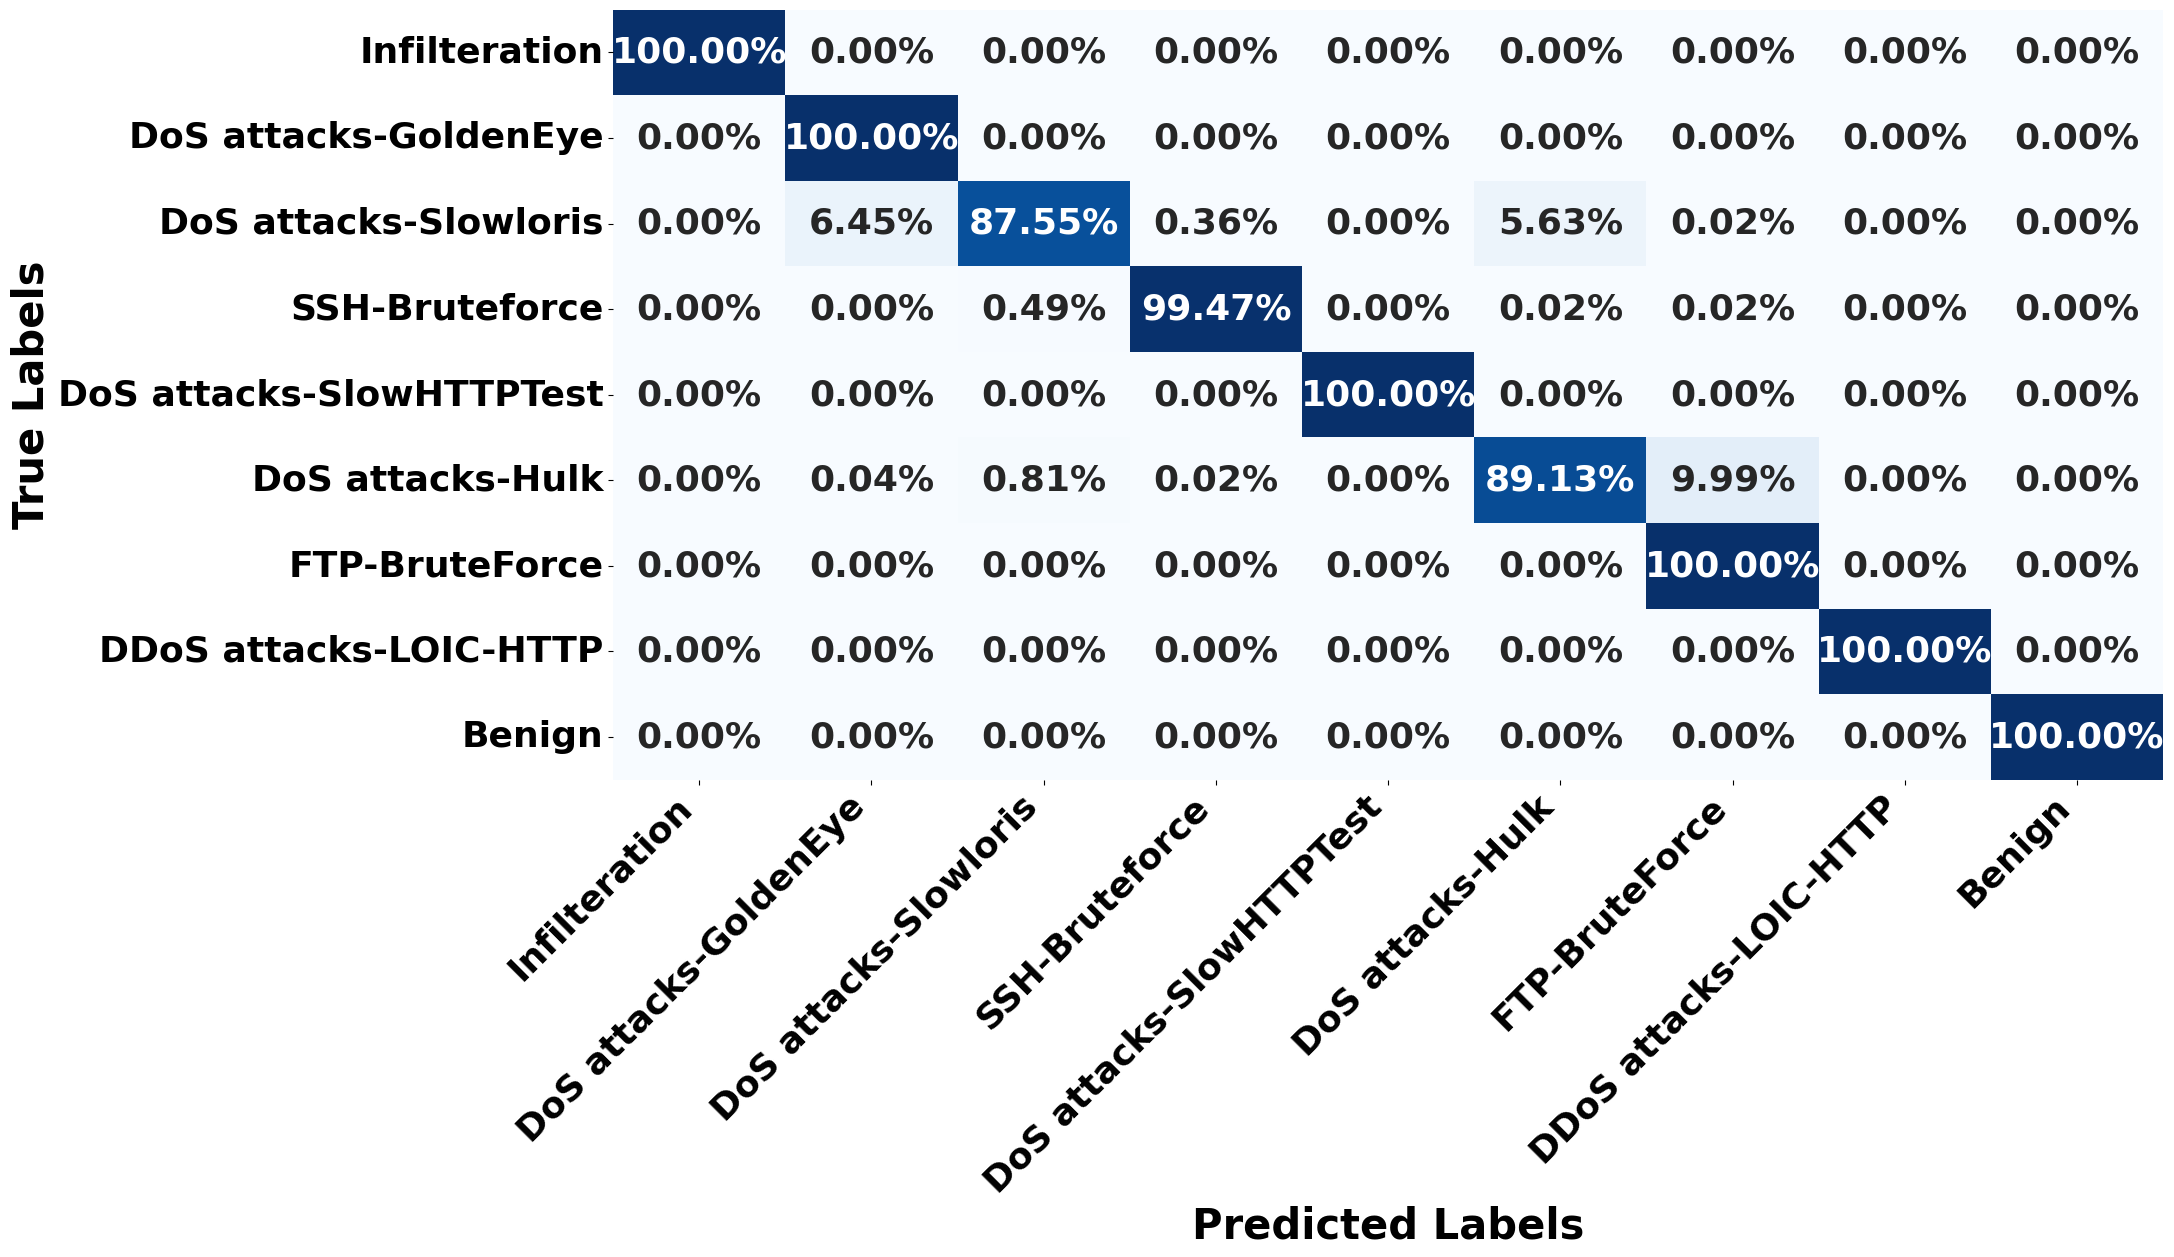

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Define the class names
class_names = [
    'Infilteration', 'DoS attacks-GoldenEye', 'DoS attacks-Slowloris',
    'SSH-Bruteforce', 'DoS attacks-SlowHTTPTest', 'DoS attacks-Hulk',
    'FTP-BruteForce', 'DDoS attacks-LOIC-HTTP', 'Benign'
]

# Check and convert y_test and y_pred_class to class labels if needed
if y_test.ndim > 1:  # If y_test is one-hot encoded
    y_test_class = y_test.argmax(axis=1)
else:
    y_test_class = y_test

if y_pred_class.ndim > 1:  # If y_pred_class has probabilities
    y_pred_class = y_pred_class.argmax(axis=1)

# Calculate the confusion matrix and normalize to show percentages
conf_matrix = confusion_matrix(y_test_class, y_pred_class)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100  # Normalize each row to percentage

# Convert the normalized confusion matrix to strings with percentage sign
conf_matrix_normalized = np.array([["{:.2f}%".format(value) for value in row] for row in conf_matrix_normalized])

# Plot the confusion matrix with percentage annotations
plt.figure(figsize=(20, 10))
sns.heatmap(conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100, annot=conf_matrix_normalized, fmt="", cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names,
            annot_kws={"fontweight": "bold", "fontsize": 26})  # Display percentages with bold formatting

# Set axis labels and title
plt.xlabel('Predicted Labels', fontweight='bold', fontsize=30)
plt.ylabel('True Labels', fontweight='bold', fontsize=30)
plt.xticks(fontsize=26, fontweight='bold', rotation=45, ha="right")
plt.yticks(fontsize=26, fontweight='bold', rotation=0)
# plt.title('Confusion Matrix (Percentage)', fontweight='bold', fontsize=16)

plt.show()


In [ ]:
y_pred

array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        1.1619694e-37, 1.0000000e+00],
       [1.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 5.3890355e-26, 1.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [0.0000000e+00, 1.4178594e-29, 5.1354213e-11, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        1.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        1.0000000e+00, 0.0000000e+00]], dtype=float32)

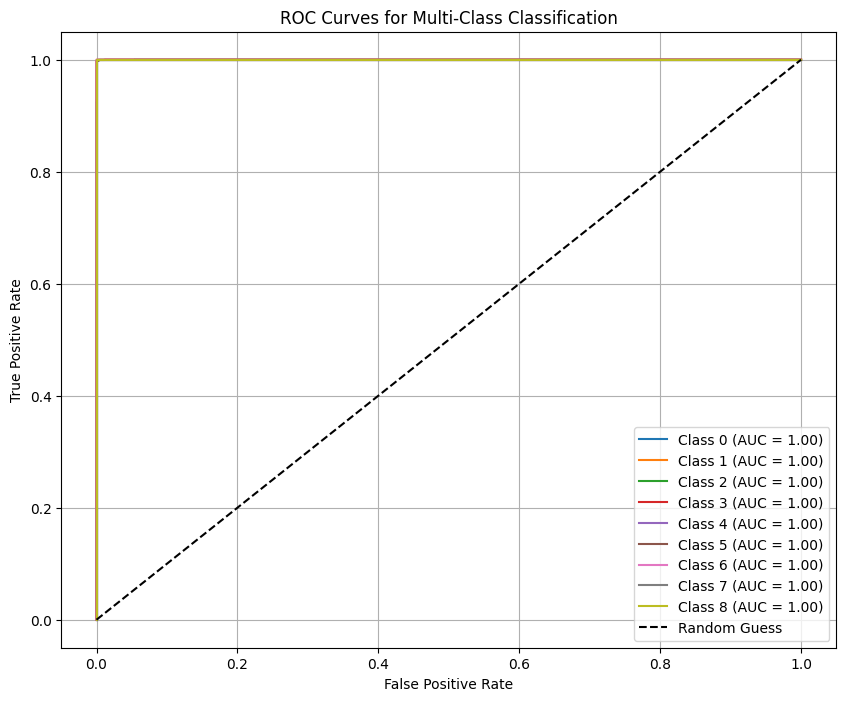

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Predict probabilities for the test set
# y_pred_prob = model.predict(X_test_cnn)

# Initialize variables
fpr = {}
tpr = {}
roc_auc = {}

# Compute ROC curve and ROC area for each class
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = roc_auc_score(y_test[:, i], y_pred[:, i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

# Plot the diagonal (random guess)
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Multi-Class Classification")
plt.legend(loc="lower right")
plt.grid()
plt.show()


# Balance Section Figure

In [ ]:
!pip install mplsoccer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.8/85.8 kB 4.2 MB/s eta 0:00:00


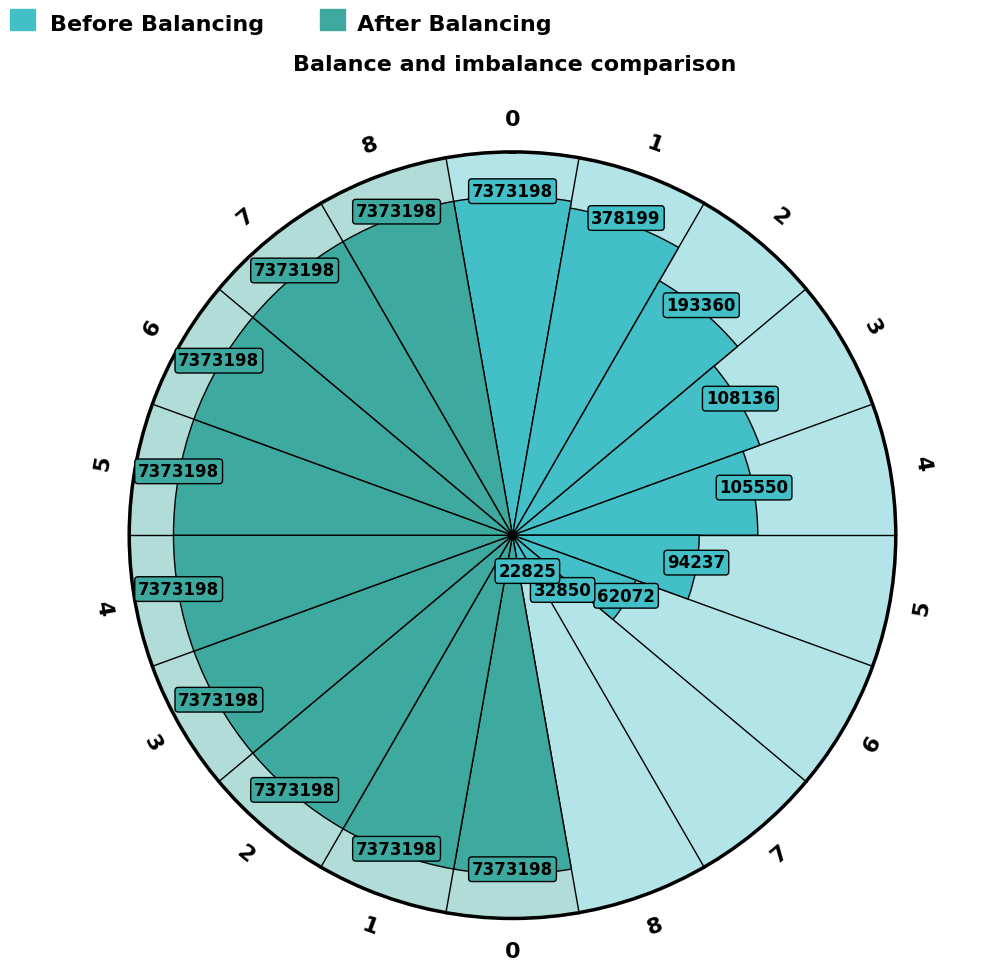

In [ ]:
from mplsoccer import PyPizza
import matplotlib.pyplot as plt

# params = ["Both_And_No_Relpse","No_GvHD_And_No_Relapse","No_GvHD_And_No_Relapse","aGvHD_And_No_Relapse","aGvHD_And_Relapse","cGvHD_And_No_Relapse","cGvHD_And_Relapse",
#          "Both_And_No_Relpse","No_GvHD_And_No_Relapse","No_GvHD_And_No_Relapse","aGvHD_And_No_Relapse","aGvHD_And_Relapse","cGvHD_And_No_Relapse","cGvHD_And_Relapse"
#           ]
params = ["0", "1", "2", "3", "4", "5", "6", "7", "8",
          "0", "1", "2", "3", "4", "5", "6",  "7", "8"]

# value list
values = [7373198, 378199, 193360, 108136, 105550, 94237, 62072, 32850, 22825,
          7373198, 7373198, 7373198, 7373198, 7373198, 7373198, 7373198, 7373198, 7373198]

# minimum range value and maximum range value for parameters
min_range = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
max_range = [8373298, 438299, 253460, 158236, 165650, 194337, 182172, 162172, 202172, 8373298, 8373298, 8373298, 8373298,
             8373298, 8373298, 8373298, 8373298, 8373298]

# color for the slices and text
slice_colors = ["#43BFC7"] * 9 + ["#3EA99F"] * 9
text_colors = ["#000000"] * 18

# instantiate PyPizza class
baker = PyPizza(
    params=params,                  # list of parameters
    min_range=min_range,            # min range values
    max_range=max_range,            # max range values
    background_color="#FFFFFF",     # background color
    straight_line_color="#000000",  # color for straight lines
    straight_line_lw=1,             # linewidth for straight lines
    last_circle_color="#000000",    # color for last line
    last_circle_lw=5,               # linewidth of last circle
    other_circle_lw=0,              # linewidth for other circles
    inner_circle_size=0             # size of inner circle
)

# plot pizza
fig, ax = baker.make_pizza(
    values,                          # list of values
    figsize=(10, 10),                # adjust the figsize according to your need
    color_blank_space="same",        # use the same color to fill blank space
    slice_colors=slice_colors,       # color for individual slices
    value_colors=text_colors,        # color for the value-text
    value_bck_colors=slice_colors,   # color for the blank spaces
    blank_alpha=0.4,                 # alpha for blank-space colors
    kwargs_slices=dict(
        edgecolor="#000000", zorder=2, linewidth=1
    ),                               # values to be used when plotting slices

    kwargs_params=dict(
        color="#000000", fontsize=16, zorder=5,
        va="center", fontweight='bold'  # Bold parameter labels
    ),                             # values to be used when adding parameter labels
    kwargs_values=dict(
        color="#000000", fontsize=12,
        zorder=5, fontweight='bold',    # Bold values
        bbox=dict(
            edgecolor="#000000", facecolor="cornflowerblue",
            boxstyle="round,pad=0.2", lw=1
        )
    )                                # values to be used when adding parameter-values labels
)

# add title
fig.text(
    0.515, 0.960, "Balance and imbalance comparison", size=16,
    ha="center", color="#000000", fontweight='bold'  # Bold title
)

# add credits
CREDIT_1 = ""
CREDIT_2 = ""

fig.text(
    0.99, 0.12, f"{CREDIT_1}\n{CREDIT_2}", size=9,
    color="#F2F2F2", ha="right"
)

# add text
fig.text(
    0.05, 1.0, "Before Balancing            After Balancing", size=16,
    color="#000000", fontweight='bold'  # Bold additional text
)

# add rectangles
fig.patches.extend([
    plt.Rectangle(
        (0.01, 1), 0.025, 0.021, fill=True, color="#43BFC7",
        transform=fig.transFigure, figure=fig
    ),
    plt.Rectangle(
        (0.32, 1), 0.025, 0.021, fill=True, color="#3EA99F",
        transform=fig.transFigure, figure=fig
    )
])

plt.show()


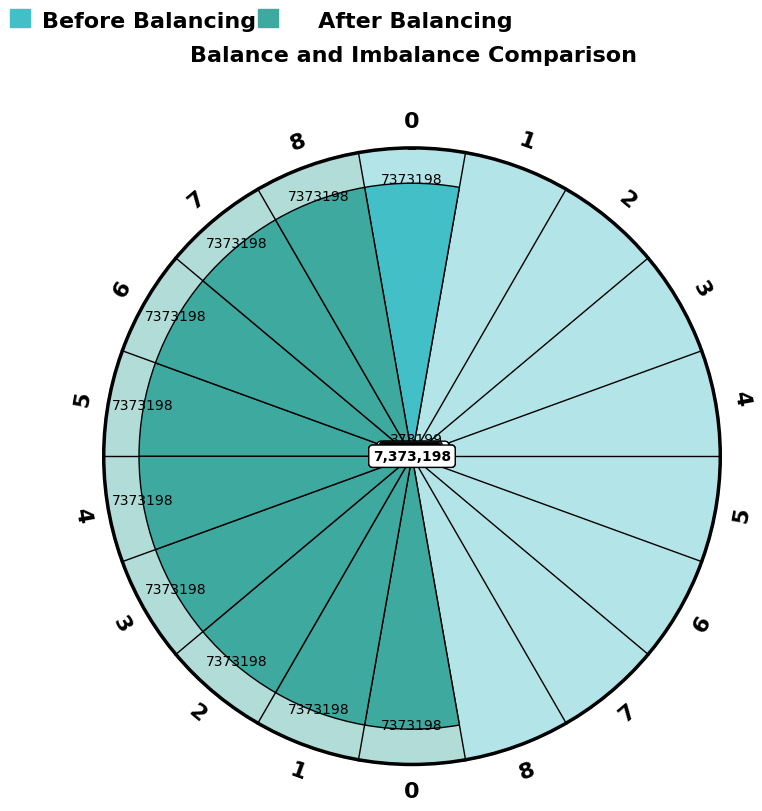

In [ ]:
from mplsoccer import PyPizza
import matplotlib.pyplot as plt
import numpy as np

# Parameters and data
params = ["0", "1", "2", "3", "4", "5", "6", "7", "8",
          "0", "1", "2", "3", "4", "5", "6", "7", "8"]
values = [7373198, 378199, 193360, 108136, 105550, 94237, 62072, 32850, 22825,
          7373198, 7373198, 7373198, 7373198, 7373198, 7373198, 7373198, 7373198, 7373198]
min_range = [0] * 18
max_range = [8373298] * 18

# Colors
slice_colors = ["#43BFC7"] * 9 + ["#3EA99F"] * 9
text_colors = ["#000000"] * 18

# Instantiate PyPizza
baker = PyPizza(
    params=params,                  # list of parameters
    min_range=min_range,            # min range values
    max_range=max_range,            # max range values
    background_color="#FFFFFF",     # background color
    straight_line_color="#000000",  # color for straight lines
    straight_line_lw=1,             # linewidth for straight lines
    last_circle_color="#000000",    # color for last line
    last_circle_lw=5,               # linewidth of last circle
    other_circle_lw=0,              # linewidth for other circles
    inner_circle_size=0             # size of inner circle
)

# Create the pizza plot
fig, ax = baker.make_pizza(
    values,                          # list of values
    figsize=(8, 8.5),                # adjust the figsize according to your need
    color_blank_space="same",        # use the same color to fill blank space
    slice_colors=slice_colors,       # color for individual slices
    value_colors=text_colors,        # color for the value-text
    value_bck_colors=slice_colors,   # color for the blank spaces
    blank_alpha=0.4,                 # alpha for blank-space colors
    kwargs_slices=dict(
        edgecolor="#000000", zorder=2, linewidth=1
    ),                               # values to be used when plotting slices

    kwargs_params=dict(
        color="#000000", fontsize=16, zorder=5,
        va="center", fontweight='bold'  # Bold parameter labels
    )
)

# Calculate angles for each slice
num_slices = len(params)
angles = np.linspace(0, 2 * np.pi, num_slices, endpoint=False)

# Manually add values outside the slices
for i, (angle, value) in enumerate(zip(angles, values)):
    # Calculate coordinates for placing text outside the slices
    x = 1.3 * np.cos(angle)  # Adjust 1.3 for distance
    y = 1.3 * np.sin(angle)
    ax.text(
        x, y, f"{value:,}", ha="center", va="center", fontsize=10, fontweight="bold",
        bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.3"),
        transform=ax.transData
    )

# Add title
fig.text(
    0.515, 0.960, "Balance and Imbalance Comparison", size=16,
    ha="center", color="#000000", fontweight='bold'  # Bold title
)

# Add legend
fig.text(
    0.05, 1.0, "Before Balancing        After Balancing", size=16,
    color="#000000", fontweight='bold'  # Bold additional text
)

# Add rectangles to explain colors
fig.patches.extend([
    plt.Rectangle(
        (0.01, 1), 0.025, 0.021, fill=True, color="#43BFC7",
        transform=fig.transFigure, figure=fig
    ),
    plt.Rectangle(
        (0.32, 1), 0.025, 0.021, fill=True, color="#3EA99F",
        transform=fig.transFigure, figure=fig
    )
])

plt.show()


<ipython-input-1-50688f784aaa>:32: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


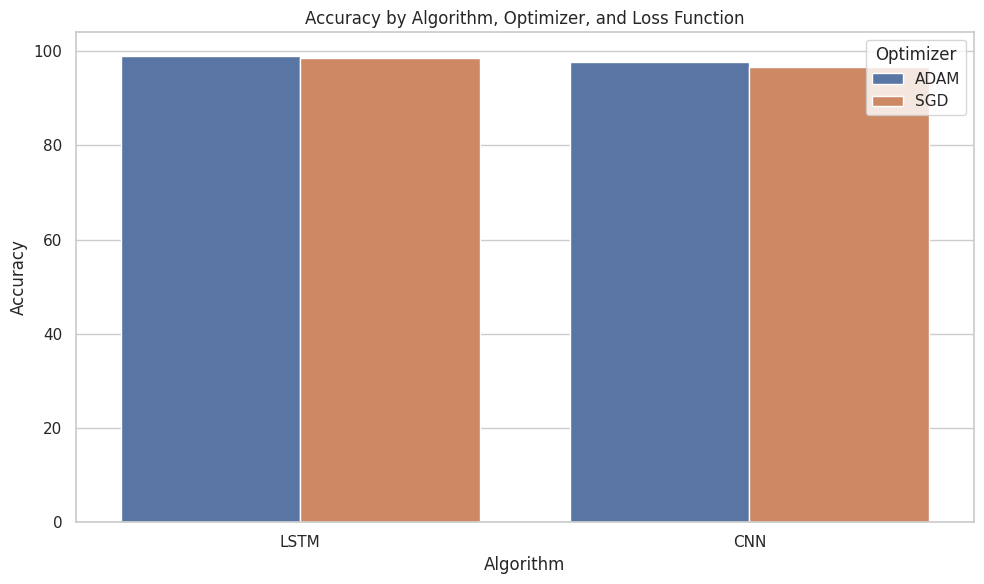

<ipython-input-1-50688f784aaa>:32: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


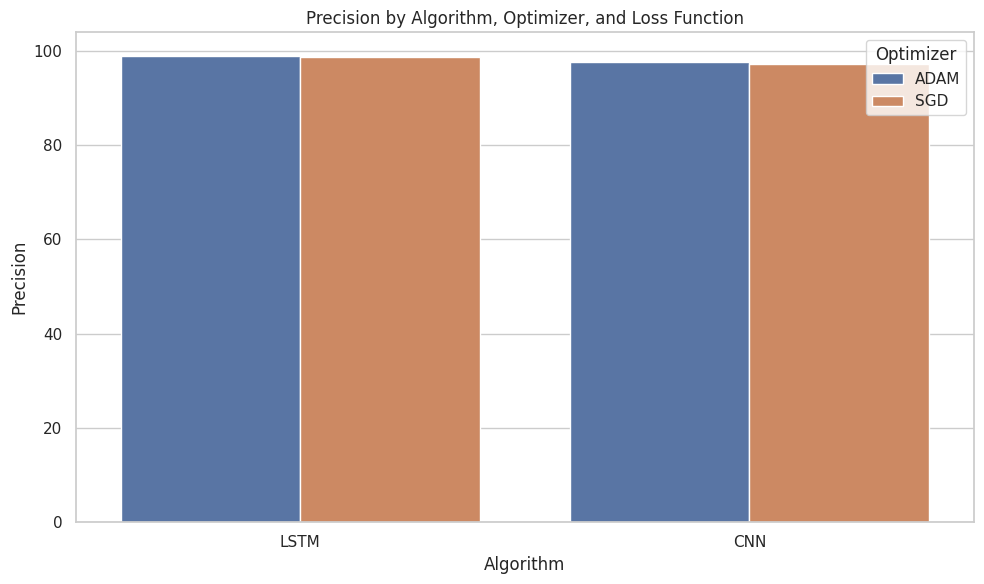

<ipython-input-1-50688f784aaa>:32: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


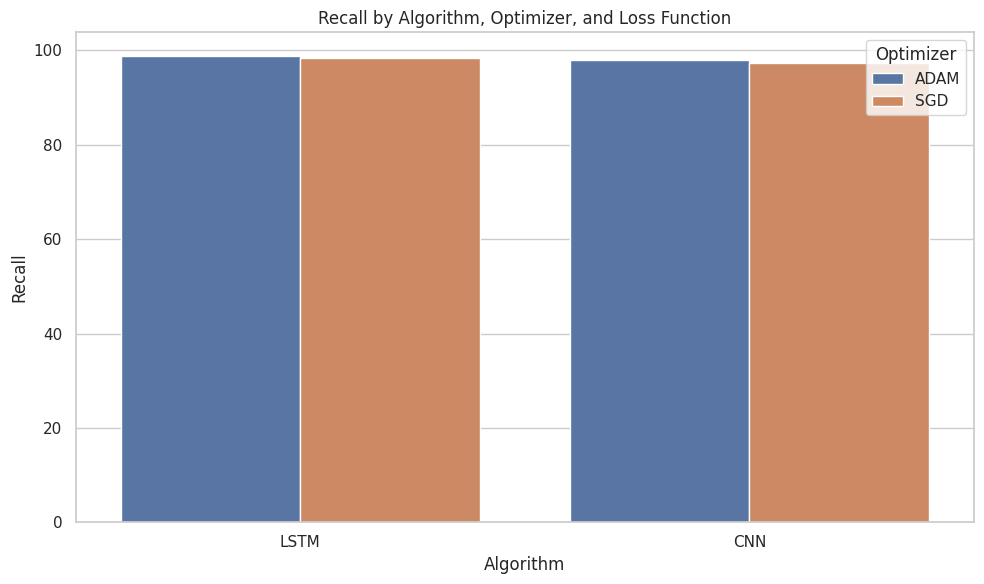

<ipython-input-1-50688f784aaa>:32: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


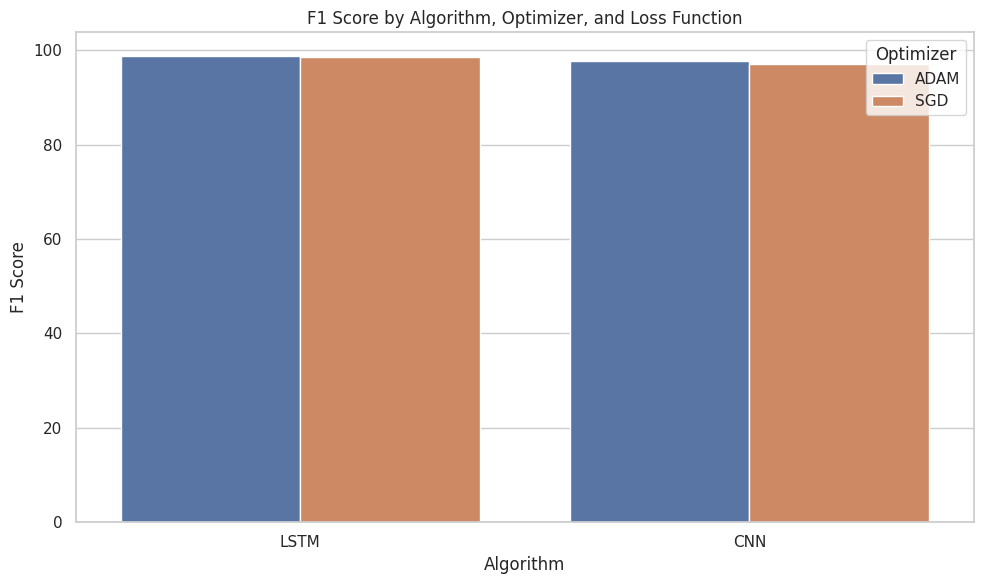

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create the dataframe
data = {
    'Algorithm': ['LSTM', 'LSTM', 'LSTM', 'LSTM', 'CNN', 'CNN', 'CNN', 'CNN'],
    'Optimizer': ['ADAM', 'ADAM', 'SGD', 'SGD', 'ADAM', 'ADAM', 'SGD', 'SGD'],
    'Loss Function': [
        'Categorical Crossentropy', 'Sparse Categorical Crossentropy',
        'Categorical Crossentropy', 'Sparse Categorical Crossentropy',
        'Categorical Crossentropy', 'Sparse Categorical Crossentropy',
        'Categorical Crossentropy', 'Sparse Categorical Crossentropy'
    ],
    'Accuracy': [99.67, 98.43, 98.49, 98.76, 97.45, 97.78, 96.04, 97.19],
    'Precision': [99.34, 98.48, 98.76, 98.57, 97.87, 97.34, 96.89, 97.34],
    'Recall': [99.65, 98.12, 98.65, 98.32, 98.12, 97.88, 97.01, 97.76],
    'F1 Score': [99.45, 98.21, 98.54, 98.47, 98.02, 97.21, 96.78, 97.38]
}

df = pd.DataFrame(data)

# Set plot style
sns.set(style="whitegrid")

# Define performance metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

# Generate plots
for metric in metrics:
    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=df,
        x='Algorithm',
        y=metric,
        hue='Optimizer',
        ci=None
    )
    plt.title(f'{metric} by Algorithm, Optimizer, and Loss Function')
    plt.ylabel(metric)
    plt.xlabel('Algorithm')
    plt.legend(title='Optimizer')
    plt.tight_layout()
    plt.show()


In [ ]:
# 5! = 1* 2*3*4*5 = 120

def find_fact(n):
  if n == 1:
    return 1
  else:
    return n* find_fact(n-1)

find_fact(5)

120

In [ ]:
5 * 24
4 * 6

3*2
2*  1